# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install -q bentoml tensorflow matplotlib

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [3]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        with tf.device("cpu:0"):  # map_fn has issues on GPU https://github.com/tensorflow/tensorflow/issues/28007
            inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## Build the image preprocessing

Ankle boot


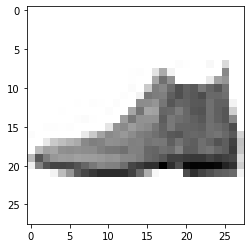

In [4]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')
plt.imsave("test.png", 255.0 - d_test_img, cmap='gray')

# read bytes
with open("test.png", "rb") as f:
    img_bytes = f.read()

# verify saved image
assert tf.reduce_mean(FashionMnist.image_bytes2tensor(tf.constant([img_bytes])) - d_test_img) < 0.01

## Train the model


In [5]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 4s 59us/sample - loss: 0.5008 - accuracy: 0.8240


## Model inference test run

In [6]:
predict = model.predict_image(tf.constant([img_bytes]))
klass = tf.argmax(predict, axis=1)
[class_names[c] for c in klass]

['Ankle boot']

And the model predicts a label as expected.

# Create BentoService class

In [7]:
%%writefile tensorflow_fashion_mnist.py

import bentoml
import tensorflow as tf
import numpy as np
from PIL import Image

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(TensorflowTensorHandler)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[c] for c in output_classes]

Overwriting tensorflow_fashion_mnist.py


In [8]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()

[2020-07-23 08:31:39,901] WARNING - bentoml.handlers.* will be deprecated after BentoML 1.0, use bentoml.adapters.* instead
[2020-07-23 08:31:39,903] WARNING - TensorflowTensorHandler will be deprecated after BentoML 1.0, use TfTensorInput instead
[2020-07-23 08:31:40,035] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/bentoml-temp-rrkuu1sj/FashionMnistTensorflow/artifacts/model_saved_model/assets
[2020-07-23 08:31:51,003] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry poin

no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.3+37.g4626764
creating BentoML-0.8.3+37.g4626764/BentoML.egg-info
creating BentoML-0.8.3+37.g4626764/bentoml
creating BentoML-0.8.3+37.g4626764/bentoml/adapters
creating BentoML-0.8.3+37.g4626764/bentoml/artifact
creating BentoML-0.8.3+37.g4626764/bentoml/cli
creating BentoML-0.8.3+37.g4626764/bentoml/clipper
creating BentoML-0.8.3+37.g4626764/bentoml/configuration
creating BentoML-0.8.3+37.g4626764/bentoml/configuration/__pycache__
creating BentoML-0.8.3+37.g4626764/bentoml/handlers
creating BentoML-0.8.3+37.g4626764/bentoml/marshal
creating BentoML-0.8.3+37.g4626764/bentoml/saved_bundle
creating BentoML-0.8.3+37.g4626764/bentoml/server
creating BentoML-0.8.3+37.g4626764/bentoml/utils
creating BentoML-0.8.3+37.g4626764/bentoml/yatai
creating BentoML-0.8.3+37.g4626764/bentoml/yatai/client
creating BentoML-0.8.3+37.g4626764/bentoml/yatai/deployment
creating BentoML-0.8.3+37.g4626764/bentoml/yatai/dep

## Use BentoService with BentoML CLI

**`bentoml get <BentoService Name>` list all of BentoService's versions**

In [13]:
!bentoml get FashionMnistTensorflow

BENTO_SERVICE                                 AGE                        APIS                                  ARTIFACTS
FashionMnistTensorflow:20200719222038_DE06B8  1 minute and 7.58 seconds  predict<TfTensorInput:DefaultOutput>  model<TensorflowSavedModelArtifact>


**`bentoml get <BentoService name>:<bentoService version>` display detailed information of the specific BentoService version**

In [15]:
!bentoml get FashionMnistTensorflow:latest

[2020-07-19 22:22:11,145] INFO - Getting latest version FashionMnistTensorflow:20200719222038_DE06B8
{
  "name": "FashionMnistTensorflow",
  "version": "20200719222038_DE06B8",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/chaoyu/bentoml/repository/FashionMnistTensorflow/20200719222038_DE06B8"
  },
  "bentoServiceMetadata": {
    "name": "FashionMnistTensorflow",
    "version": "20200719222038_DE06B8",
    "createdAt": "2020-07-20T05:20:57.511519Z",
    "env": {
      "condaEnv": "name: bentoml-FashionMnistTensorflow\nchannels:\n- defaults\ndependencies:\n- python=3.7.5\n- pip\n",
      "pipDependencies": "tensorflow\nbentoml==0.8.3\nnumpy\npillow",
      "pythonVersion": "3.7.5",
      "dockerBaseImage": "bentoml/model-server:0.8.3"
    },
    "artifacts": [
      {
        "name": "model",
        "artifactType": "TensorflowSavedModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "inputType": "TfTensorInput",
        "docs": "BentoService API",

**Serve bentoml REST server locally**

In [16]:
!bentoml serve FashionMnistTensorflow:latest

[2020-07-19 22:22:15,053] INFO - Getting latest version FashionMnistTensorflow:20200719222038_DE06B8
[2020-07-19 22:22:18,712] WARNING - bentoml.handlers.* will be deprecated after BentoML 1.0, use bentoml.adapters.* instead
[2020-07-19 22:22:18,713] WARNING - TensorflowTensorHandler will be deprecated after BentoML 1.0, use TfTensorInput instead
2020-07-19 22:22:18.925997: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-07-19 22:22:18.946186: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f95871c8720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-07-19 22:22:18.946223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
 * Serving Flask app "FashionMnistTensorflow" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Runn

## Query REST API with python

In [1]:
import base64
import json
import requests

with open("test.png", "rb") as f:
    img_bytes = f.read()
img_b64 = base64.b64encode(img_bytes).decode()


headers = {"content-type": "application/json"}
data = json.dumps(
       {"instances": [{"b64": img_b64}]}
)
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

json_response = requests.post(f'http://localhost:5000/predict', data=data, headers=headers)
print(json_response)
print(json_response.text)

Data: {"instances": [{"b64": "iVBORw0KGgoAAAANSUhEUgAAAB ... ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII="}]}
<Response [200]>
["Ankle boot"]


# Use BentoService as PyPI package

`pip install $SAVED_PATH` also installs a CLI tool for accessing the BentoML service

In [3]:
!pip install {saved_path}

Processing /home/bentoml/bentoml/repository/FashionMnistTensorflow/20200723083140_4A85D5
  Created wheel for FashionMnistTensorflow: filename=FashionMnistTensorflow-20200723083140_4A85D5-py3-none-any.whl size=1139229 sha256=8c8e5665546f58b7246d8dfae239eff6e349d14d43318fb57a83be575de1a15f
  Stored in directory: /tmp/pip-ephem-wheel-cache-fesvg5p7/wheels/ad/62/32/9e80224574e37cc1c4920da2eeb72690c471ea8eb6d106fdb8
Successfully built FashionMnistTensorflow
  Attempting uninstall: FashionMnistTensorflow
    Found existing installation: FashionMnistTensorflow 20200723081930-47CA61
    Uninstalling FashionMnistTensorflow-20200723081930-47CA61:
      Successfully uninstalled FashionMnistTensorflow-20200723081930-47CA61


In [4]:
!FashionMnistTensorflow --help

Usage: FashionMnistTensorflow [OPTIONS] COMMAND [ARGS]...

  BentoML CLI tool

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  containerize        Containerizes given Bento into a ready-to-use Docker
                      image

  info                List APIs
  install-completion  Install shell command completion
  open-api-spec       Display OpenAPI/Swagger JSON specs
  run                 Run API function
  serve               Start local dev API server
  serve-gunicorn      Start production API server


### Run 'predict' api with json data:

In [8]:
!echo '{\"instances\":[{\"b64\":\"'$(base64 test.png)'\"}]}' > test.json
!cat test.json | xargs -I {} FashionMnistTensorflow run predict --input={}

2020-07-23 08:35:42.485465: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-23 08:35:42.498660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-23 08:35:42.499011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2020-07-23 08:35:42.499162: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-23 08:35:42.500530: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-23 08:35:42.501843: I tensorflow/stream_executor/platform/

## Build realtime prediction service in docker with BentoService

In [ ]:
!cd {saved_path} && docker build -t tensorflow2-fashion-mnist .

In [ ]:
!docker run -p 5000:5000 tensorflow2-fashion-mnist

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this demo, we are going to deploy to AWS Sagemaker

In [ ]:
bento_service_tag = f'{bento_svc.name}:{bento_svc.version}'
print(bento_service_tag)

In [ ]:
!bentoml sagemaker deploy first-tf-fashion -b {bento_service_tag} --api-name predict --verbose

In [ ]:
!bentoml sagemaker get first-tf-fashion

In [ ]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name dev-first-tf-fashion --content-type 'application/json' \
--body "{\"instances\":[{\"b64\":\"iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA2dJREFUSIntlk9L60oYh59Mp43axJoiVj2KboSuXPoJXLkQ/Fx+Ahe6ceFG3CtdWlFcFf9RKlhFatpSbWuaNLHJnIW3OR7ugcu9BzxccGAgZCbv887v/b1JNKWU4hOH+EzYF/AL+OeBYRjysct83wegUqn8HlApRRRFADw+PrK/v4/jOCQSCTRNi/fpug7AwcHB7wEBhHh/9Pj4mGKxyM7Ozt/2NBoNdnd3MU0zvif/CywMQ6SUnJ+fc3NzQy6Xo1KpsLGxgWVZ9Pt9FhYWaLVadLtd5ubmfiT6b2FRFCGlxHEc9vf3UUrR7/d5fX1FKRXPq6srpJRYlsVgMPhn4LD4URTF12EYxlJubW2Ry+WYnp7G8zz6/T65XC6uYzqdRtd1fN+n2+3iOM6vgcPgw+ILIdA0jTAMSSQSAOzt7WHbNtPT0xiGQbvdJpvNMjU1RTKZJAxD3t7e4ni9Xo/b29tfA4egKIoYDAZxAkPYzs4OpVKJ+fl5Wq0W7XYbz/PIZDK8vr6iaRpjY2Mkk0mUUnG8w8ND4INphjbXNA2lFEKIWD6AWq3GwcEBnuextLSE4zj4vk+r1SKVSqFpGq7rxsnpuo4QgnQ6jRCCYrH4DhxK9TH4MKtms0m1WqVcLvP09EQqlWJ8fJx2u0232+Xt7Q3f9xFCUK1WGQwGTExMkEwmEUKglGJ0dJQwDDEMg8vLS+RQqnq9zv39Pb1ej16vh+d53N3d4bouUkpM0ySKIjqdDp7nIaXEdV1GR0fRdZ0gCJidnaXT6eC6LpZl4TgOLy8vpNNpbNvm+fn5XdJCoUCtVkNKSbPZjA0yBDmOg23bKKXwfR/LsoiiCMdxCMOQdDqNYRhkMhkajUaslGVZCCHwPI8gCJBSIo+Ojtje3iafzzMzMxOfJJVKxe9G0zQJggAhRNxvnuehaRpRFGHbNvV6nevra4IgIAxDAAzDwHVddF3HMAympqaQKysrnJ6ecnFx8aOwf50sm82SzWbJZDIEQYBSilarRblcxnVdut0umqZRKpVYXl5mcXGRQqGA7/uxD6SUfPv2DdM031388SfKcRzOzs4ol8ucnJzQbDZ/atqhA7PZLPl8ntXVVdbW1hgZGYnX19fXeXh4YHJyEtM0MU0TKSW6rrO5ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII=\"}]}" \
output.json && cat output.json

In [ ]:
!bentoml sagemaker delete first-tf-fashion --force